In [0]:
import pandas as pd
import numpy as np

import re
import requests
import lxml.html as lh
import operator

import seaborn as sns

In [0]:
url = "https://www.wpc.ncep.noaa.gov/tropical/rain/tcmaxima.html"
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

In [0]:
cyclones = tr_elements[1:]

#Iterate through each cyclone

# these lists can later be used to 
# create a dataframe
name, year, rain = [], [], []
for cyclone in cyclones:
  i = 0
  for child in cyclone.iterchildren():
      data = child.text_content()
      data = re.sub('\s+',' ',data).strip(" ")
      # print(data)

      # get the name and year
      if i == 0:
        l = data.replace("(","").replace(")","").split(" ")
        if len(l) != 3:
          break
        nm, month, yr = l
        try:
          yr = int(yr)
        except:
          pass
        name.append(nm)
        year.append(yr)

      # get the rainfall amount
      if i==1:
        data = data.replace("+","").split(" ")
        try:
          rainfall_amt = 0.0
          for x in data:
            rainfall_amt = max(rainfall_amt, float(x))
        except:
          pass
        rain.append(rainfall_amt)
      i+=1


In [4]:
len(name), len(year), len(rain)

(560, 560, 560)

In [0]:
# form a dictionary
dc = {}
for nm, yr, rn in zip(name, year, rain):
  dc[(nm.upper(), yr)] = rn

In [6]:
from google.colab import drive
drive.mount('/content/drive')

% cd '/content/drive/My Drive/omdena-data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/omdena-data


In [7]:
df = pd.read_csv('./ibtracs_tcedat_emdat_names_merge.csv')
df.head(3)

,SID,ISO,NAME,BASIN,SUBBASIN,NATURE,TRACK_TYPE,ISO_TIME,COORDS,TOTAL_HRS,DAY_HRS,NIGHT_HRS,USA_SSHS,YEAR_min,YEAR_max,WMO_WIND_min,WMO_WIND_max,WMO_WIND_mean,WIND_CALC_min,WIND_CALC_max,WIND_CALC_mean,WMO_PRES_min,WMO_PRES_max,WMO_PRES_mean,PRES_CALC_min,PRES_CALC_max,PRES_CALC_mean,STORM_SPD_min,STORM_SPD_max,STORM_SPD_mean,STORM_DR_min,STORM_DR_max,STORM_DR_mean,year,IBTrACS_ID,TC_name,NatCatSERVICE_ID,genesis_basin,countries_affected,ISO3,...,Group,Subgroup,Type,Subtype,Subsubtype,Event name,Entry criteria,Country name,Region,Continent,EU member,Location,Origin,Associated disater,Associated disater 2,OFDA response,Appeal,Declaration,Aid contribution ('000$),Magnitude (value),Magnitude (scale),Latitude,Longitude,Local time,River basin,Start year,Start month,Start day,End year,End month,End day,Total deaths,Num injured,Num affected,Num homeless,Total affected,Reconstruction cost ('000$),Insured losses ('000$),Total damage ('000$),CPI
0,1949163N07145,JPN,DELLA,WP,MM,ET,main,"['1949-06-20 15:00:00', '1949-06-20 18:00:00',...","[[31.99, 130.68], [33.52, 130.97], [41.0, 140....",12.0,0.0,12.0,-1.0,1949.0,1949.0,NaN,NaN,NaN,23.0,60.2,40.90,NaN,NaN,NaN,967.0,1003.0,986.375,12.0,33.0,21.50,7.0,75.0,40.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Natural,Meteorological,Storm,Tropical cyclone,NaN,DELLA,Kill,Japan,Eastern Asia,Asia,No,Western Japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kph,NaN,NaN,NaN,NaN,1949,6.0,NaN,1949,6.0,NaN,419.0,NaN,194046.0,NaN,194046.0,NaN,NaN,NaN,9.327572
1,1949313N06137,PHL,RENA,WP,MM,TS,main,"['1949-11-11 09:00:00', '1949-11-11 15:00:00',...","[[9.49, 125.55], [9.99, 124.0], [10.3, 123.13]...",12.0,11.0,1.0,0.0,1949.0,1949.0,NaN,NaN,NaN,56.0,57.6,56.95,NaN,NaN,NaN,992.0,993.0,992.750,15.0,19.0,17.75,289.0,299.0,292.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Natural,Meteorological,Storm,Tropical cyclone,NaN,RENA,Kill,Philippines (the),South-Eastern Asia,Asia,No,"Cebu City, Negros, Panay",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kph,NaN,NaN,NaN,NaN,1949,10.0,31.0,1949,10.0,31.0,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.327572
2,1950241N23140,JPN,JANE,WP,MM,TS,main,"['1950-09-03 03:00:00', '1950-09-03 06:00:00',...","[[34.94, 135.48], [36.1, 136.09], [37.27, 136....",21.0,0.0,21.0,0.0,1950.0,1950.0,NaN,NaN,NaN,40.0,77.6,60.90,NaN,NaN,NaN,961.5,993.0,973.500,25.0,29.0,27.00,21.0,46.0,31.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Natural,Meteorological,Storm,Tropical cyclone,NaN,JANE,Kill,Japan,Eastern Asia,Asia,No,Entire nation except Kyushu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kph,NaN,NaN,NaN,NaN,1950,9.0,NaN,1950,9.0,NaN,509.0,NaN,642117.0,NaN,642117.0,NaN,NaN,NaN,9.431937


In [8]:
df.columns.values

array(['SID', 'ISO', 'NAME', 'BASIN', 'SUBBASIN', 'NATURE', 'TRACK_TYPE',
       'ISO_TIME', 'COORDS', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS',
       'USA_SSHS', 'YEAR_min', 'YEAR_max', 'WMO_WIND_min', 'WMO_WIND_max',
       'WMO_WIND_mean', 'WIND_CALC_min', 'WIND_CALC_max',
       'WIND_CALC_mean', 'WMO_PRES_min', 'WMO_PRES_max', 'WMO_PRES_mean',
       'PRES_CALC_min', 'PRES_CALC_max', 'PRES_CALC_mean',
       'STORM_SPD_min', 'STORM_SPD_max', 'STORM_SPD_mean', 'STORM_DR_min',
       'STORM_DR_max', 'STORM_DR_mean', 'year', 'IBTrACS_ID', 'TC_name',
       'NatCatSERVICE_ID', 'genesis_basin', 'countries_affected', 'ISO3',
       'v_land_SI', 'v_land_kn', '34kn_pop', '34kn_assets', '64kn_pop',
       '64kn_assets', '96kn_pop', '96kn_assets', 'ibtracs_name',
       'merged_name', 'Year', 'Seq', 'Group', 'Subgroup', 'Type',
       'Subtype', 'Subsubtype', 'Event name', 'Entry criteria',
       'Country name', 'Region', 'Continent', 'EU member', 'Location',
       'Origin', 'Associated disat

In [0]:
def get_perc_values(df):
  # get the percentage of values per column
  return sorted({k:round(v/df.shape[0],3) for k,v in dict(df.notnull().sum()).items()}.items(), key=operator.itemgetter(1), reverse=True)

In [12]:
get_perc_values(df)

[('SID', 1.0),
 ('ISO', 1.0),
 ('NAME', 1.0),
 ('NATURE', 1.0),
 ('TRACK_TYPE', 1.0),
 ('ISO_TIME', 1.0),
 ('COORDS', 1.0),
 ('TOTAL_HRS', 1.0),
 ('DAY_HRS', 1.0),
 ('NIGHT_HRS', 1.0),
 ('YEAR_min', 1.0),
 ('YEAR_max', 1.0),
 ('STORM_SPD_min', 1.0),
 ('STORM_SPD_max', 1.0),
 ('STORM_SPD_mean', 1.0),
 ('STORM_DR_min', 1.0),
 ('STORM_DR_max', 1.0),
 ('STORM_DR_mean', 1.0),
 ('Year', 1.0),
 ('Seq', 1.0),
 ('Group', 1.0),
 ('Subgroup', 1.0),
 ('Type', 1.0),
 ('Subtype', 1.0),
 ('Event name', 1.0),
 ('Entry criteria', 1.0),
 ('Country name', 1.0),
 ('Region', 1.0),
 ('Continent', 1.0),
 ('EU member', 1.0),
 ('Magnitude (scale)', 1.0),
 ('Start year', 1.0),
 ('End year', 1.0),
 ('CPI', 1.0),
 ('USA_SSHS', 0.999),
 ('Start month', 0.997),
 ('End month', 0.997),
 ('WIND_CALC_min', 0.99),
 ('WIND_CALC_max', 0.99),
 ('WIND_CALC_mean', 0.99),
 ('PRES_CALC_min', 0.966),
 ('PRES_CALC_max', 0.966),
 ('PRES_CALC_mean', 0.966),
 ('Start day', 0.951),
 ('End day', 0.951),
 ('Location', 0.942),
 ('Total

In [0]:
df['Rain'] = np.nan
not_present = []
for index, row in df.iterrows():
  yr = row['Year']
  nm = row['NAME']
  if (nm, yr) in dc:
    df.loc[index,'Rain'] = dc[(nm,yr)]
  else:
    if yr >= 1956:
      not_present.append((nm, yr))


In [15]:
df['Rain'].describe()

count    203.000000
mean      18.286108
std       10.449746
min        3.430000
25%       12.255000
50%       17.230000
75%       21.330000
max      100.390000
Name: Rain, dtype: float64

In [0]:
# eda - see the relationship between rain and the response variables
df_rain = df[df['Rain'].notna()]

In [17]:
df_rain.shape

(203, 93)

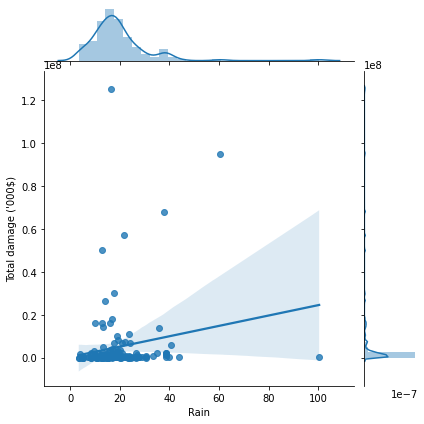

In [19]:
sns.jointplot(x='Rain', y="Total damage ('000$)", data=df_rain, kind="reg")

In [0]:
"""
Summary: I was able to extract only 203 records with rainfall data from the url. 
Data only available for cyclones that impacted the U.S. from
1956 onward to the present, and Mexico between 1995 and 2003.
There appears to be some relation between damage and rainfall. Need to look and see 
if there are other agencies from where the rainfall data can be sources
"""

In [101]:
# df = pd.DataFrame(list(zip(name, year, rain)), 
#                columns =['Name', 'Year', 'Rain']) 
# df.head(3)

,Name,Year,Rain
0,Olga,2019,10.24
1,Nestor,2019,7.77
2,Karen,2019,5.71


In [102]:
# df['Rain'].describe()

count    560.000000
mean      13.358893
std        9.558563
min        0.330000
25%        7.025000
50%       11.370000
75%       17.332500
max      100.390000
Name: Rain, dtype: float64